In [1]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")   # type: ignore

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PYG_GRAPHS = torch.load("data/processed/pyg_graphs_384D.pt", weights_only=False)

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.4


In [2]:
## HELPER FUNCTIONS FOR CREATING AND TRAINING MODEL
import importlib
import src.models.multitask_debate_gnn
importlib.reload(src.models.multitask_debate_gnn)

from src.models.multitask_debate_gnn import ECCConv, MultitaskDebateGNN, train_gnn_live, plot_cv_losses
from torch_geometric.nn import GCNConv, SAGEConv

from typing import Dict, Any, Type, Optional

def create_and_describe_model(model_args: Dict[str, Any], model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN) -> Optional[MultitaskDebateGNN]:
    """Build the model from args, print a summary, and return the instance (or None on failure)."""
    try:
        model = model_class(**model_args)
        print("Model created:")
        print(f"   Architecture: {[type(conv).__name__ for conv in model.convs]}")
        print(f"   Mode: {model.mode}")
        print(f"   Input dim: {model_args['in_dim']}")
        print(f"   Hidden dim: {model_args['hidden_dim']}")
        print(f"   Embedding dim: {model_args['emb_dim']}")
        print(f"   Number of layers: {model_args['num_layers']}")

        # Count parameters
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        print("\nModel Statistics:")
        print(f"   Total parameters: {total_params:,}")
        print(f"   Trainable parameters: {trainable_params:,}")
        print(f"   Model size: ~{total_params * 4 / 1024**2:.1f} MB")

        # Show model structure
        print("\nModel Structure:")
        print(model)
        return model

    except Exception as e:
        print(f"Error creating model: {e}")
        import traceback
        traceback.print_exc()
        return None
    
def run_cv_training(
    graph_data,
    model_args: dict,
    train_args: dict,
    model_class: Type[MultitaskDebateGNN] = MultitaskDebateGNN,
    live_plot: bool = False,):
    """
    Runs cross-validation training with cleanup and plotting.
    Returns (model, results, cv_history) or (None, None, None) on failure.
    """
    import gc, traceback
    import torch

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    try:
        model, results, cv_history = train_gnn_live(
            all_graphs=getattr(graph_data, "pyg_graphs", graph_data),
            model_args=model_args,
            train_args=train_args,
            model_class=model_class,
            live_plot=live_plot,
        )
        plot_cv_losses(cv_history=cv_history)
        return model, results, cv_history
    except Exception as e:
        print(f"Training error: {e}")
        traceback.print_exc()
        return None, None, None

In [3]:
# BASE MODEL AND TRAINING ARGS (shared across all variants)
BASE_MODEL_ARGS = dict(
    in_dim = 384,
    hidden_dim = 256,
    emb_dim = 128,
    neg_attr_weight = 0.3,
    dropout = 0.15,
)

ECC_KWARGS = dict(
    edge_mlp_dropout = 0.1,
    keep_prob = 0.8,
    conf_dim = 1,
    stance_dim = 3
)

BASE_TRAIN_ARGS = dict(
    epochs = 30,
    lr = 0.001,
    patience = 6,
    min_delta = 3e-4,
    neg_sample_ratio = 0.5,
    temp_reg_weight = 0.1,
    val_n_last = 1, # or val_pct_last = 0.25 (pick either one)
    val_gap_n = 1,
    task_weights = {"link": 1.0, "conf": 1.0, "stance": 1.0}
)

# To store cv results later
TRAIN_RESULTS = {
    "3-ECC": None,
    "1-ECC-2-SAGE": None,
    "1-SAGE-2-ECC": None,
    "2-SAGE-1-ECC": None,
}
TRAINED_MODELS = {
    "3-ECC": None,
    "1-ECC-2-SAGE": None,
    "1-SAGE-2-ECC": None,
    "2-SAGE-1-ECC": None,
}

In [4]:
# DEFINE VARIANTS ARGS

# 1. 3-ECC -> Full
_3ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls=ECCConv,
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

# 2. 1-ECC-2-SAGE -> Full
_1ecc_2sage_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[ECCConv, SAGEConv, SAGEConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

# 3. 1-SAGE-2-ECC -> Full
_1sage_2ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[SAGEConv, ECCConv, ECCConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

# 4. 2-SAGE-1-ECC -> Full
_2sage_1ecc_F_margs = BASE_MODEL_ARGS | dict(
    num_layers=3,
    mode="full",
    conv_cls_list=[SAGEConv, SAGEConv, ECCConv],
    ecc_kwargs=ECC_KWARGS   # Share ECC args for all with ECC layer
)

### **3-ECC** (Full)

Training 3-ECC...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,084 nodes | 938 edges | Avg: 93.8 edges/graph
   + Stance Dist: [0.322, 0.239, 0.439] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,291 nodes | 4,297 edges | Avg: 165.3 edges/graph
   + Stance Dist: [0.407, 0.283, 0.310] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 7,302 nodes | 8,143 edges | Avg: 904.8 edges/graph
   + Stance Dist: [0.360, 0.216, 0.424] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,417 nodes | 7,598 edges | Avg: 844.2 edges/graph
   + Stance Dist: [0.401, 0.246, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,380
  - Total edges: 35,556
  - Avg nod

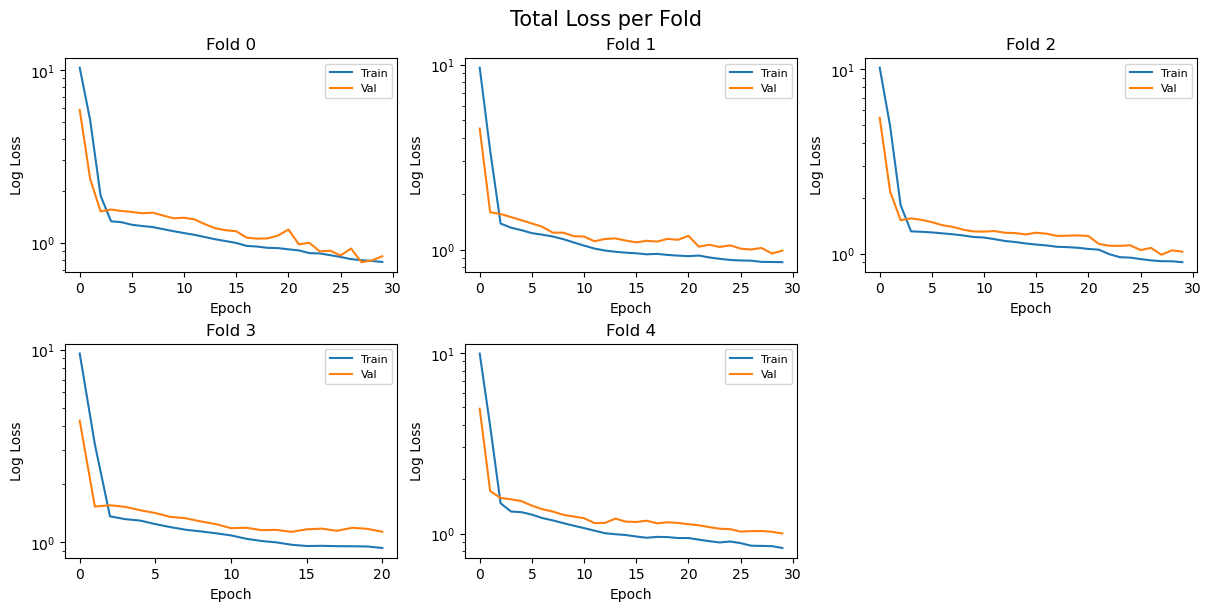

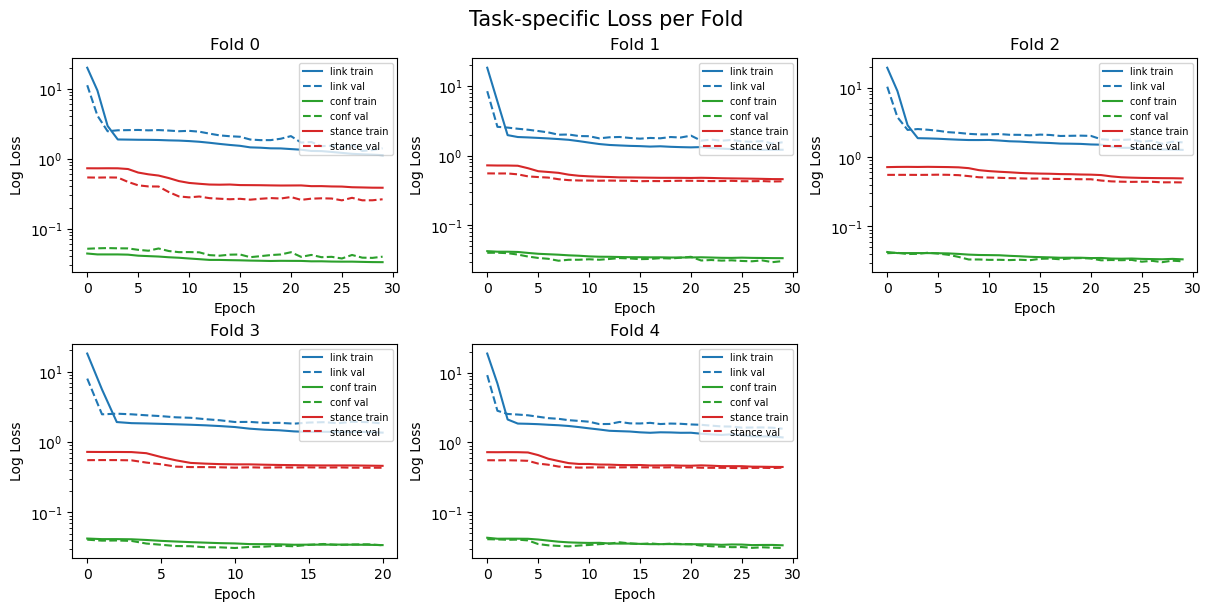

In [6]:
print("Training 3-ECC...")
_3ecc_model, _3ecc_results, _3ecc_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _3ecc_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['3-ECC'] = _3ecc_results
TRAINED_MODELS['3-ECC'] = _3ecc_model

### **1-ECC-2-SAGE** (Full)

Training 1-ECC-2-SAGE...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,084 nodes | 938 edges | Avg: 93.8 edges/graph
   + Stance Dist: [0.322, 0.239, 0.439] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,291 nodes | 4,297 edges | Avg: 165.3 edges/graph
   + Stance Dist: [0.407, 0.283, 0.310] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 7,302 nodes | 8,143 edges | Avg: 904.8 edges/graph
   + Stance Dist: [0.360, 0.216, 0.424] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,417 nodes | 7,598 edges | Avg: 844.2 edges/graph
   + Stance Dist: [0.401, 0.246, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,380
  - Total edges: 35,556
  - 


Epoch   0:
  - Train: Total=10.2922 | Link=19.8177 | Conf=0.0427 | Stance=0.7284
  - Val:   Total=5.9602 | Link=11.3344 | Conf=0.0504 | Stance=0.5408
  - Uncertainty: Link=1.000 | Conf=1.000 | Stance=1.000
  - LR: 1.00e-04

Epoch  20:
  - Train: Total=0.7322 | Link=0.7504 | Conf=0.0317 | Stance=0.6853
  - Val:   Total=0.8522 | Link=1.1700 | Conf=0.0367 | Stance=0.5168
  - Uncertainty: Link=0.999 | Conf=0.987 | Stance=0.986
  - LR: 1.00e-04
  Early stopping at epoch 22

Final Evaluation on Test Subreddit 0:

Test Metrics for 0:
   - Link Auc: 0.8035
   - Conf Mae: 0.3441
   - Conf Nll: 0.7014
   - Stance Nll: 1.0978
   - Stance Kl: 1.0680

Training for Test Subreddit: 1

Data Split with Temporal Gap (1 timesteps):
  - Training: 3 subreddits + early timesteps from val 0 → 65 graphs
    Train subreddits: [2, 3, 4, '0 (partial)']
  - Validation: Subreddit 0 latest timestep(s): [22] → 1 graph(s)
  - Temporal Gap (g=1): Subreddit 0 timestep(s) skipped: [21]
  - Testing: Subreddit 1 → 10 gra

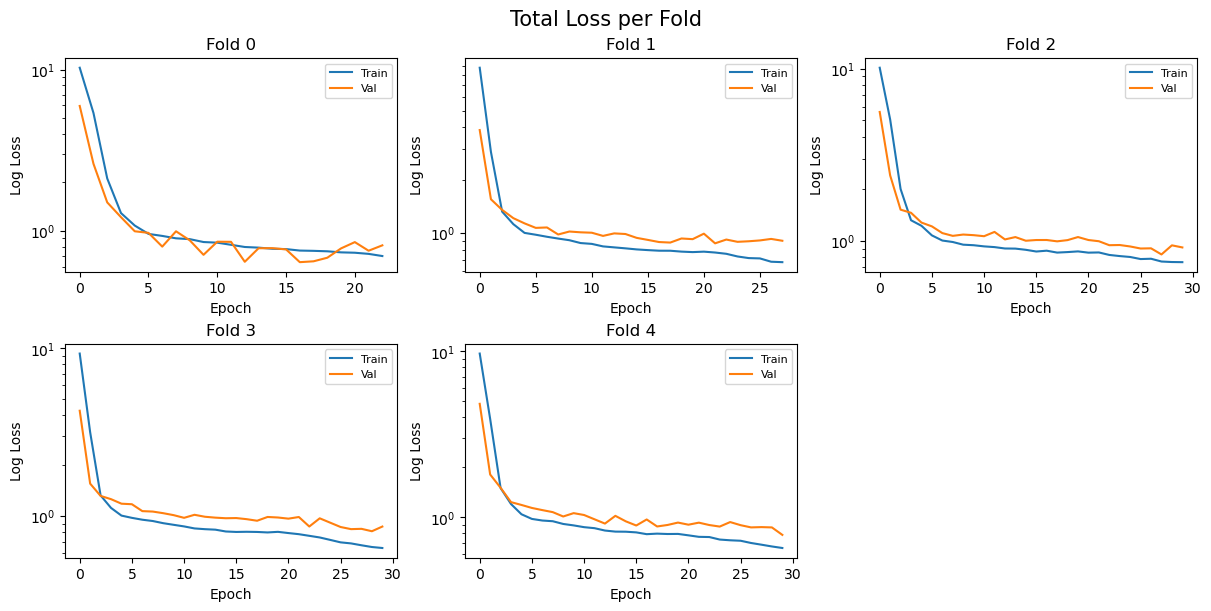

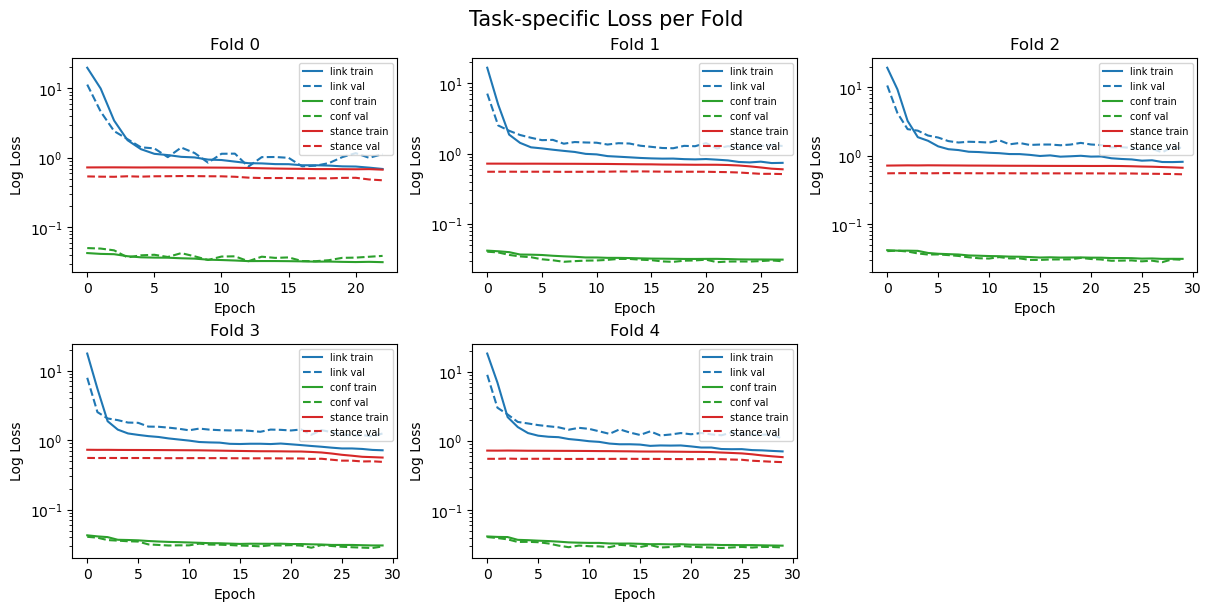

In [7]:
print("Training 1-ECC-2-SAGE...")
_1ecc_2sage_F_model, _1ecc_2sage_F_results, _1ecc_2sage_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _1ecc_2sage_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['1-ECC-2-SAGE'] = _1ecc_2sage_F_results
TRAINED_MODELS['1-ECC-2-SAGE'] = _1ecc_2sage_F_model

### **1-SAGE-2-ECC** (Full)

Training 1-SAGE-2-ECC...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,084 nodes | 938 edges | Avg: 93.8 edges/graph
   + Stance Dist: [0.322, 0.239, 0.439] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,291 nodes | 4,297 edges | Avg: 165.3 edges/graph
   + Stance Dist: [0.407, 0.283, 0.310] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 7,302 nodes | 8,143 edges | Avg: 904.8 edges/graph
   + Stance Dist: [0.360, 0.216, 0.424] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,417 nodes | 7,598 edges | Avg: 844.2 edges/graph
   + Stance Dist: [0.401, 0.246, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,380
  - Total edges: 35,556
  - 

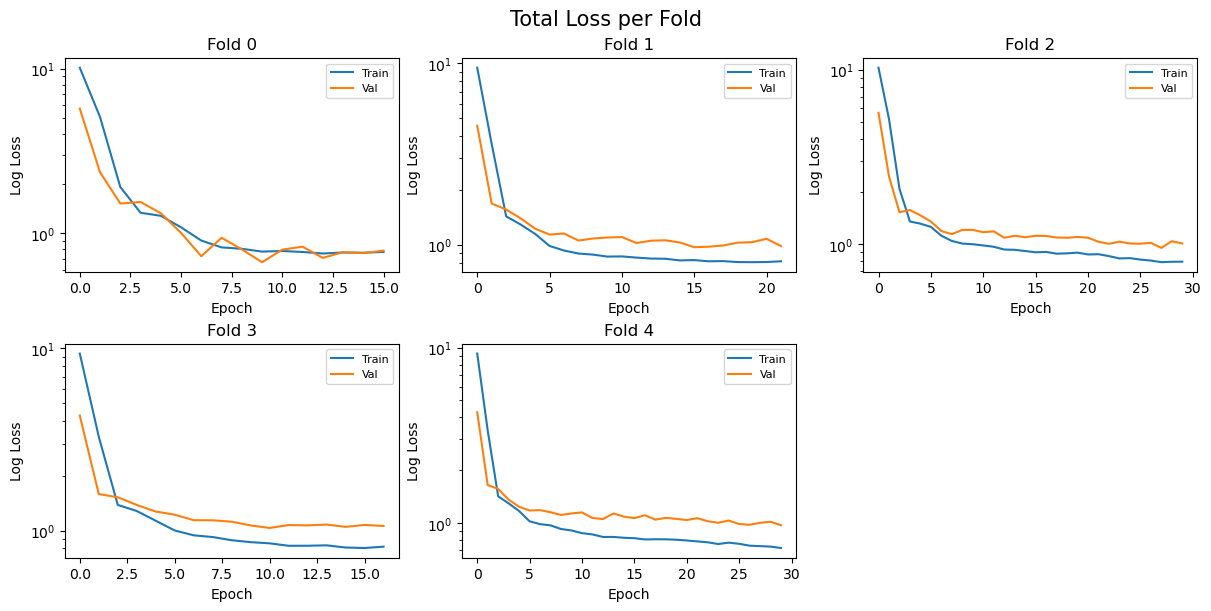

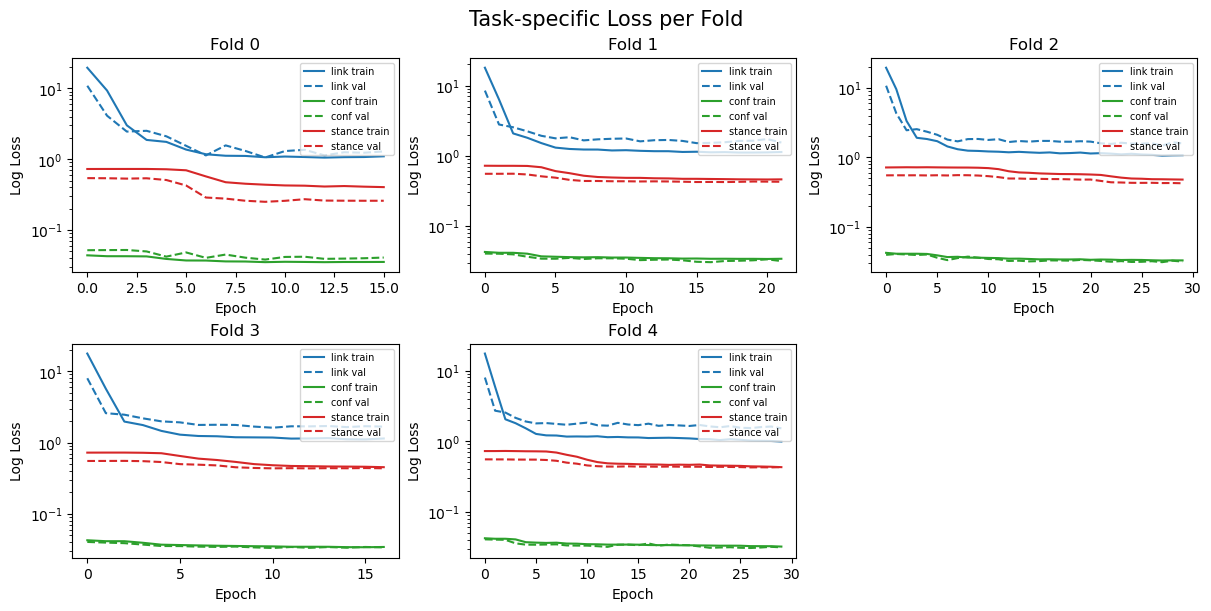

In [8]:
print("Training 1-SAGE-2-ECC...")
_1sage_2ecc_F_model, _1sage_2ecc_F_results, _1sage_2ecc_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _1sage_2ecc_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['1-SAGE-2-ECC'] = _1sage_2ecc_F_results
TRAINED_MODELS['1-SAGE-2-ECC'] = _1sage_2ecc_F_model

### **2-SAGE-1-ECC** (Full)

Training 2-SAGE-1-ECC...

Dataset Overview:
  - Total graphs: 77
  - Device: cuda
  - Training mode: full
  - Task weights: {'link': 1.0, 'conf': 1.0, 'stance': 1.0}
  - Tasks: Link, Confidence, Stance
   + Subreddit 0: 23 graphs | 4,286 nodes | 14,580 edges | Avg: 633.9 edges/graph
   + Stance Dist: [0.414, 0.290, 0.296] (disagree/neutral/agree)
   + Subreddit 1: 10 graphs | 1,084 nodes | 938 edges | Avg: 93.8 edges/graph
   + Stance Dist: [0.322, 0.239, 0.439] (disagree/neutral/agree)
   + Subreddit 2: 26 graphs | 4,291 nodes | 4,297 edges | Avg: 165.3 edges/graph
   + Stance Dist: [0.407, 0.283, 0.310] (disagree/neutral/agree)
   + Subreddit 3: 9 graphs | 7,302 nodes | 8,143 edges | Avg: 904.8 edges/graph
   + Stance Dist: [0.360, 0.216, 0.424] (disagree/neutral/agree)
   + Subreddit 4: 9 graphs | 7,417 nodes | 7,598 edges | Avg: 844.2 edges/graph
   + Stance Dist: [0.401, 0.246, 0.353] (disagree/neutral/agree)

Global Statistics:
  - Total nodes: 24,380
  - Total edges: 35,556
  - 


Epoch   0:
  - Train: Total=9.7561 | Link=18.7439 | Conf=0.0430 | Stance=0.7293
  - Val:   Total=5.1508 | Link=9.7152 | Conf=0.0509 | Stance=0.5400
  - Uncertainty: Link=1.000 | Conf=1.000 | Stance=1.000
  - LR: 1.00e-04

Epoch  20:
  - Train: Total=0.6423 | Link=0.8245 | Conf=0.0320 | Stance=0.4251
  - Val:   Total=0.7549 | Link=1.2368 | Conf=0.0395 | Stance=0.2567
  - Uncertainty: Link=1.000 | Conf=0.987 | Stance=0.985
  - LR: 1.00e-04
  Early stopping at epoch 23

Final Evaluation on Test Subreddit 0:

Test Metrics for 0:
   - Link Auc: 0.8126
   - Conf Mae: 0.3342
   - Conf Nll: 0.7025
   - Stance Nll: 0.8433
   - Stance Kl: 0.8135

Training for Test Subreddit: 1

Data Split with Temporal Gap (1 timesteps):
  - Training: 3 subreddits + early timesteps from val 0 → 65 graphs
    Train subreddits: [2, 3, 4, '0 (partial)']
  - Validation: Subreddit 0 latest timestep(s): [22] → 1 graph(s)
  - Temporal Gap (g=1): Subreddit 0 timestep(s) skipped: [21]
  - Testing: Subreddit 1 → 10 graph

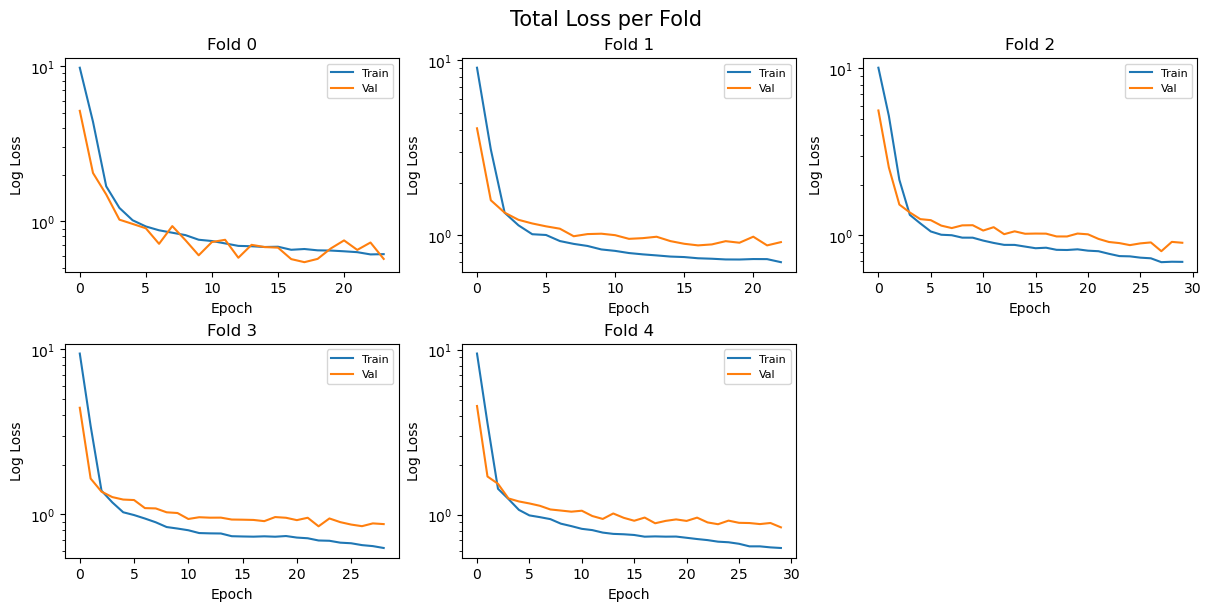

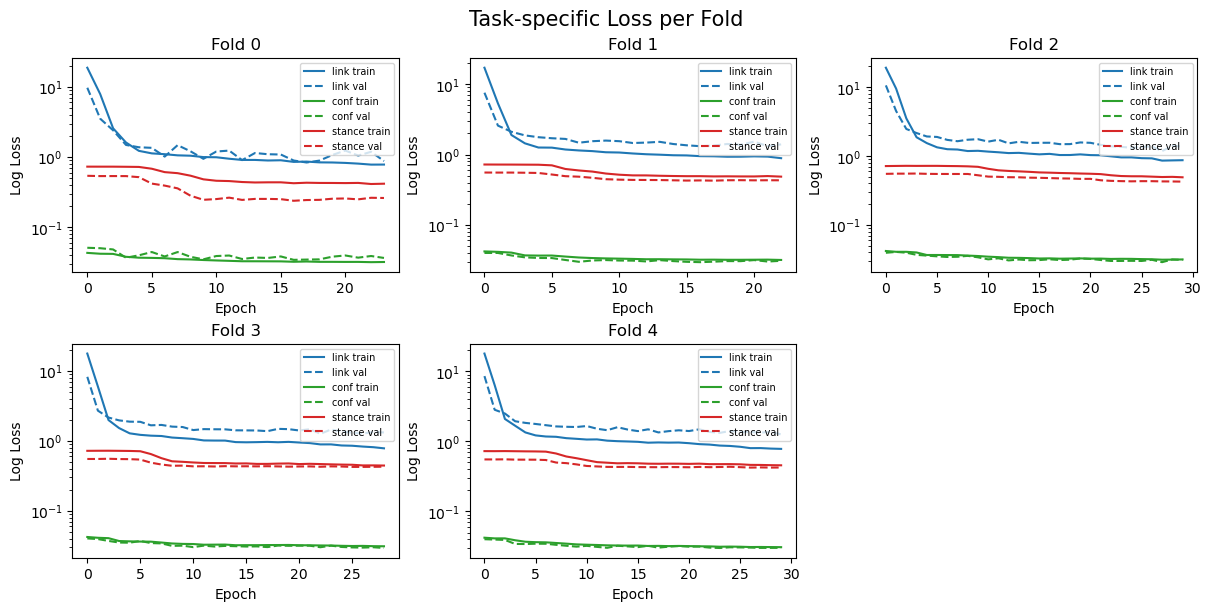

In [9]:
print("Training 2-SAGE-1-ECC...")
_2sage_1ecc_F_model, _2sage_1ecc_F_results, _2sage_1ecc_F_cv_history = run_cv_training(
    graph_data = PYG_GRAPHS,
    model_args = _2sage_1ecc_F_margs,
    train_args = BASE_TRAIN_ARGS,
    model_class = MultitaskDebateGNN,
    live_plot = False
)
# Save trained model and result to dict
TRAIN_RESULTS['2-SAGE-1-ECC'] = _2sage_1ecc_F_results
TRAINED_MODELS['2-SAGE-1-ECC'] = _2sage_1ecc_F_model

### **FINAL RESULTS**

In [10]:
import pandas as pd

records = []
for variant, fold_dict in TRAIN_RESULTS.items():
    for fold_id, metrics in fold_dict.items():
        rec = {"variant": variant, "fold": fold_id}
        rec.update(metrics)
        records.append(rec)

df = pd.DataFrame.from_records(records)
wide = (df.pivot(index="fold", columns="variant").sort_index())
wide.loc["MEAN"] = wide.mean()
wide = wide.round(3)
wide

link_auc                                      conf_mae  \
variant 1-ECC-2-SAGE 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC 1-ECC-2-SAGE   
fold                                                                 
0              0.804        0.663        0.813  0.775        0.344   
1              0.914        0.850        0.896  0.895        0.349   
2              0.911        0.852        0.890  0.848        0.353   
3              0.930        0.833        0.917  0.850        0.351   
4              0.919        0.877        0.913  0.879        0.357   
MEAN           0.895        0.815        0.886  0.849        0.351   

                                             conf_nll               \
variant 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC 1-ECC-2-SAGE 1-SAGE-2-ECC   
fold                                                                 
0              0.311        0.334  0.326        0.701        0.716   
1              0.340        0.335  0.332        0.715        0.731   
2              0.340        0.345  0.334        0.731        0.803   
3              0.344        0.347  0.340        0.710        0.708   
4              0.342        0.347  0.341        0.704        0.710   
MEAN           0.335        0.342  0.335        0.713        0.734   

                              stance_nll                                   \
variant 2-SAGE-1-ECC  3-ECC 1-ECC-2-SAGE 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC   
fold                                                                        
0              0.703  0.699        1.098        0.836        0.843  0.823   
1              0.685  0.730        1.107        0.440        0.436  0.460   
2              0.734  0.777        1.055        0.564        0.552  0.594   
3              0.700  0.691        0.901        0.627        0.578  0.596   
4              0.727  0.730        0.890        0.535        0.556  0.589   
MEAN           0.710  0.725        1.010        0.600        0.593  0.612   

           stance_kl                                   
variant 1-ECC-2-SAGE 1-SAGE-2-ECC 2-SAGE-1-ECC  3-ECC  
fold                                                   
0              1.068        0.806        0.813  0.794  
1              1.101        0.434        0.431  0.454  
2              1.053        0.562        0.550  0.592  
3              0.899        0.625        0.576  0.593  
4              0.889        0.533        0.554  0.588  
MEAN           1.002        0.592        0.585  0.604

In [11]:
df_mean = df.drop(columns="fold").groupby("variant").mean(numeric_only=True).round(3)
df_mean

,link_auc,conf_mae,conf_nll,stance_nll,stance_kl
variant,,,,,
1-ECC-2-SAGE,0.895,0.351,0.713,1.010,1.002
1-SAGE-2-ECC,0.815,0.335,0.734,0.600,0.592
2-SAGE-1-ECC,0.886,0.342,0.710,0.593,0.585
3-ECC,0.849,0.335,0.725,0.612,0.604


In [12]:
print("Saved summary to 'results/ablation/layer_variant_summary.csv'")
df_mean.to_csv("results/ablation/layer_variant_summary.csv")

print("Saved all fold results to 'results/ablation/layer_variant_all_folds.csv'")
wide.to_csv("results/ablation/layer_variant_all_folds.csv")

Saved summary to 'results/ablation/layer_variant_summary.csv'
Saved all fold results to 'results/ablation/layer_variant_all_folds.csv'


### **Save Best Model (2-SAGE-1-ECC)**

In [13]:
import importlib
import src.utils
importlib.reload(src.utils)

from src.utils import save_model_checkpoint

best_model = TRAINED_MODELS['2-SAGE-1-ECC']
assert best_model is not None, "Model not found."
best_model_args = _2sage_1ecc_F_margs
best_model_train_args = BASE_TRAIN_ARGS

path = save_model_checkpoint(
    best_model, 
    best_model_args, 
    best_model_train_args,
    out_dir="checkpoints", 
    prefix="best_model"
)
print(f"Best model checkpoint path: {path}")

Saved model checkpoint to checkpoints/best_model_2509011326.pth
Best model checkpoint path: checkpoints/best_model_2509011326.pth
